# Variational Autoencoder (VAE) for Face Generation

This project implements a **Variational Autoencoder (VAE)** from scratch using **PyTorch** and trains it on the **CelebA dataset** to generate realistic human face images.

The project includes:
- Data preprocessing
- Latent space modeling
- Probabilistic interpretation of the encoder output
- Reparameterization trick for backpropagation
- Stable training on GPU

the model is able to **sample from a learned latent space** and generate new faces from learned distribution.

## Dataset

- **CelebA (Large-scale CelebFaces Attributes Dataset)**
- Images resized to **64×64**
- Pixel values normalized to **[-1, 1]**


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader



if torch.cuda.is_available():
    device = torch.device("cuda")
    cudnn.benchmark = True
else:
  raise ValueError("GPU is not available. Change Colab runtime.")

<h3>Data Pipeline (Preprocessing & Loading)</h3>


Images are preprocessed and loaded using torchvision utilities to ensure
consistent input size and normalization for stable VAE training.

In [5]:
transform = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

dataset = datasets.CelebA(
    root = "./data",
    transform=transform,
    split="train",
    download=True
)
dataloader = DataLoader(
    dataset = dataset, 
    batch_size=32, 
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

Files already downloaded and verified


## Model Architecture

The VAE consists of three components:
- A convolutional **Encoder** that maps images to latent distributions
- A **Reparameterization** step that enables backpropagation through sampling
- A convolutional **Decoder** that reconstructs images from latent vectors

### Encoder

The encoder maps an input image to two vectors:
- **μ (mean)** of the latent distribution
- **log σ² (log-variance)** of the latent distribution

Both are learned directly by the network.


### Reparameterization

Sampling is rewritten as a differentiable operation to allow gradient flow
through the latent variables.

### Decoder

The decoder maps latent vectors back to image space using transposed
convolutions. 

In [6]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)

        self.flatten = nn.Flatten()

        self.mu = nn.Linear(256*4*4, latent_dim)
        self.logvar = nn.Linear(256*4*4, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        x = self.flatten(x)

        mu = self.mu(x)
        logvar = self.logvar(x)

        return mu, logvar
    
def reparam(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)

    return mu + eps * std


class Decoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim

        self.fc = nn.Linear(latent_dim, 256*4*4)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(256, 4, 4))

        self.deconv1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1)


    def forward(self, z):
        x = F.relu(self.fc(z))
        x = self.unflatten(x)

        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = torch.tanh(self.deconv4(x)) #tanh to match [-1,1] also do not use F.tanh 

        return x
    


class VAE(nn.Module):
    def __init__(self, latent_dim = 128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = reparam(mu, logvar)
        output = self.decoder(z)

        return output, mu, logvar

## Loss Function

The VAE is trained by minimizing a combination of:
- **Reconstruction loss**, which encourages accurate image reconstruction
- **KL divergence**, which regularizes the latent space to follow a standard
  normal distribution

In [13]:
def vae_loss(x, output, mu, logvar):
    recon_loss = F.mse_loss(output, x, reduction='sum')  
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = recon_loss + kl_loss
    return loss

## Training Loop

In [14]:
def train_vae(model, optimizer, loss_function, dataloader, epochs, device):

    model.train()
    epoch_losses = []

    for epoch in range(epochs):
        total_loss = 0.0
        total_samples = 0

        for images, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):

            images = images.to(device)
            optimizer.zero_grad()

            output, mu, logvar = model(images)
            loss = loss_function(images, output, mu, logvar)

            loss.backward()
            optimizer.step()


            total_loss += loss.item()
            total_samples += images.size(0)

        epoch_loss = total_loss / total_samples
        epoch_losses.append(epoch_loss)

        print(f"Epoch [{epoch+1}/{epochs}] Average Loss per image: {epoch_loss:.4f}")

    return epoch_losses

vae = VAE(latent_dim=128).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
epochs = 12 

epoch_losses = train_vae(
    model=vae,
    optimizer=optimizer,
    loss_function=vae_loss,
    dataloader=dataloader, 
    epochs=epochs,
    device=device
)



Epoch 1/12: 100%|██████████| 5087/5087 [01:33<00:00, 54.37it/s]


Epoch [1/12] Average Loss per image: 714.1295


Epoch 2/12: 100%|██████████| 5087/5087 [00:45<00:00, 111.36it/s]


Epoch [2/12] Average Loss per image: 506.7058


Epoch 3/12: 100%|██████████| 5087/5087 [00:45<00:00, 111.75it/s]


Epoch [3/12] Average Loss per image: 474.7852


Epoch 4/12: 100%|██████████| 5087/5087 [00:45<00:00, 111.00it/s]


Epoch [4/12] Average Loss per image: 457.9601


Epoch 5/12: 100%|██████████| 5087/5087 [00:45<00:00, 111.46it/s]


Epoch [5/12] Average Loss per image: 449.2836


Epoch 6/12: 100%|██████████| 5087/5087 [00:45<00:00, 110.95it/s]


Epoch [6/12] Average Loss per image: 443.7053


Epoch 7/12: 100%|██████████| 5087/5087 [00:45<00:00, 111.45it/s]


Epoch [7/12] Average Loss per image: 439.9606


Epoch 8/12: 100%|██████████| 5087/5087 [00:45<00:00, 111.19it/s]


Epoch [8/12] Average Loss per image: 437.3044


Epoch 9/12: 100%|██████████| 5087/5087 [00:45<00:00, 111.14it/s]


Epoch [9/12] Average Loss per image: 434.9794


Epoch 10/12: 100%|██████████| 5087/5087 [00:45<00:00, 111.15it/s]


Epoch [10/12] Average Loss per image: 433.1818


Epoch 11/12: 100%|██████████| 5087/5087 [00:46<00:00, 110.58it/s]


Epoch [11/12] Average Loss per image: 431.6455


Epoch 12/12: 100%|██████████| 5087/5087 [00:45<00:00, 111.61it/s]

Epoch [12/12] Average Loss per image: 430.4693


## Sampling and Visualization

After training, new face images are generated by sampling random vectors from
a standard normal distribution in latent space and passing them through the
decoder.

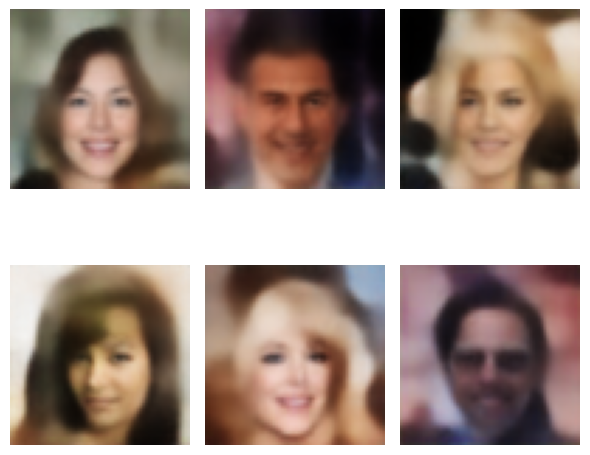

In [90]:
vae.eval()

num_samples = 6
z = torch.randn(num_samples, 128).to(device) 
with torch.no_grad():  
    samples = vae.decoder(z)  


samples = (samples + 1) / 2.0
samples = samples.cpu()  
samples = samples.permute(0, 2, 3, 1)  


fig, axes = plt.subplots(2, 3, figsize=(6,6))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].numpy())
    ax.axis('off') 

plt.tight_layout()
plt.show()